# Seattle vs Boston - Battle of the Cities 

In [1]:
# Import the libraries
import pandas as pd
import zipfile
import re
import html 
import numpy as np
import folium
from folium.plugins import MarkerCluster
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
nltk.set_proxy('10.6.25.96:80')
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abfs386\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<img src = "Seattle.png" width="450" height="200" align='left'> <img src = "Boston.png" width="450" height="200" align='right'> 


In [2]:
#Import datasets
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/calendar.csv.zip") # having calendar.csv zipped file.
df_calanderS = pd.read_csv(zf.open("calendar.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/calendar.csv (1).zip") # having calendar.csv zipped file.
df_calanderB = pd.read_csv(zf.open("calendar.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/listings.csv.zip") # having calendar.csv zipped file.
df_listingsS = pd.read_csv(zf.open("listings.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/listings.csv (1).zip") # having calendar.csv zipped file.
df_listingsB = pd.read_csv(zf.open("listings.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/reviews.csv.zip") # having calendar.csv zipped file.
df_reviewsS = pd.read_csv(zf.open("reviews.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/reviews.csv (1).zip") # having calendar.csv zipped file.
df_reviewsB = pd.read_csv(zf.open("reviews.csv"))

In [3]:
# Merge the review data to listings data to get all the reviews for the listings  
df_Seattle = df_reviewsS.merge(df_listingsS, left_on = 'listing_id', right_on = 'id', how = 'left')
df_Boston = df_reviewsB.merge(df_listingsB, left_on = 'listing_id', right_on = 'id', how = 'left')

In [4]:
# Create an indicator for the cities for later checks
df_Seattle['CityIndicator'] = 'Seattle'
df_Boston['CityIndicator'] = 'Boston'

In [5]:
# Drop the columns that is not needed and this is to append the datasets
dropcols = list(set(df_Boston.columns) - set(df_Seattle.columns))
df_Boston = df_Boston.drop(dropcols, axis = 1)

In [6]:
# Final dataset 
df_Final = df_Seattle.append(df_Boston[df_Seattle.columns], ignore_index = True)

In [7]:
#remove all the $ signs and make value flaot
df_Final.price = df_Final.price.str.replace('$','')
df_Final.price = df_Final.price.str.replace(',','').astype(float)

In [8]:
#add all the attractions for Boston and Seatlle to plot on folium and create a dataframe
attraction_listS = [['Pike Place Market', 47.6084, -122.3405], 
 ['Space Needle', 47.6205, -122.3493], 
 ['Olympic Sculpture Park', 47.6166, -122.3553],
 ['Washington State Ferries', 47.602722, -122.338512],
 ['Museum of History & Industry', 47.6276, -122.3366],
 ['Downtown waterfront', 47.6094, -122.3422],
 ['Seattle Art Museum', 47.6073, -122.3381],
 ['Chinatown International District', 47.5987, -122.3240],
 ['Ballard Locks', 47.6655, -122.3972],
 ['Seattle Aquarium', 47.6074,-122.3430]]
df_attractionsS = pd.DataFrame(data = attraction_listS, columns = ['attraction','longitude','latitude'])

attraction_listB = [['Freedom Trail', 42.3560, -71.0541], 
 ['Fenway Park', 42.3467, -71.0972], 
 ['Boston Theater District', 42.3519, -71.0643],
 ['Tea Party Ships & Museum', 42.3522, -71.0513],
 ['Museum of Fine Arts', 42.3394, -71.0940],
 ['Public Garden, Make Way for Ducklings, & Swan Boats', 42.3542,-71.0704],
 ['New England Aquarium', 42.3591, -71.0498],
 ['Beacon Hill', 42.3588, -71.0707],
 ['Newbury Street', 42.3481, -71.0879],
 ['Harvard', 42.3770, -71.1167]]
df_attractionsB = pd.DataFrame(data = attraction_listB, columns = ['attraction','longitude','latitude'])

In [9]:
#Create a definition to plot the longitude and the latitude for the attractions as well as all the locations where a listing is present
def mapplot(data, Coordinates, City, attractionList, zoom, price, visits):
    """Summary or Description of the Function:
    This function is to plot the locations on folium. The longitude and latitude is provided.
        
    Parameters:
    data (dataframe): df_Final that is used  
    Coordinates (int,int) this is the x and y coordinate 
    City (str) city for which the plot is applicable
    zoom (float) size of zoom
    price (int) avarage price where 75% confidance interval
    visits (int) average visits per neighbourhood

    Returns:
    plot of the map

   """
    m = folium.Map(location=Coordinates, zoom_start=zoom)
    marker_cluster = MarkerCluster().add_to(m)

    count_value = data[data.CityIndicator == City].groupby('neighbourhood').agg({'listing_id':'count','price':'mean'}).reset_index()
    unique_prop = data[data.CityIndicator == City].drop_duplicates(subset = 'neighbourhood')
    unique_prop = unique_prop[['neighbourhood', 'longitude', 'latitude']].dropna(subset = {'neighbourhood'})
    unique_prop = unique_prop.merge(count_value, on = 'neighbourhood')
    print(count_value.describe())
    for index, row in unique_prop.iterrows():
        html = """Neighbourhood: {0} <br>
                  Count: {1} <br>
                  Average Price: ${2}""".format(row[0], row[3], round(row[4],2))
        iframe = folium.IFrame(html=html,width=250, height=100)
        popup= folium.Popup(iframe, max_width=500)
        if (row[4] >= price) and (row[3] >= visits):
            colour = 'orange'
        elif (row[4] < price) and (row[3] >= visits):
            colour = 'purple'
        else:
            colour = 'green'
        folium.Marker([row['latitude'], row['longitude']], popup = popup, icon=folium.Icon(color = colour)).add_to(m)

    for index, row in attractionList.iterrows():
        html = """{0}""".format(row[0])
        iframe = folium.IFrame(html=html,width=200, height=30)
        popup= folium.Popup(iframe, max_width=500)
        icon = folium.Icon(icon = 'tower', color = 'black')
        folium.Marker([row[1], row[2]], icon=icon, popup=popup).add_to(m)
    

    return(m)

# 1. The average price that is charged in relation to the location of the listings
### Overview
The question that is on everyones lips, where is all the attractions at? How far am I from them and would I get value for money. In this analysis we looked at the physical locations of each of the listings on AirBnB for two Cities (Seattle and Boston). From the analysis the following is clear:

1. The average listing price that is paid per night in Boston is higher than Seattle
2. The number of visits per neighborhood in Boston is more than in Seattle
3. There are more listings are available in Seattle than in Boston

### Seattle

1. \$ 111 is the average price charged and the average number of visits per property is 1000 these properties are indicated by the orange markers, and they fall around the main attractions is Seattle    
2. For listings where the price is below the average price, but have higher than average visits - regarded as cheaper is marked in purple
3. The green markers show the rest of the group that fall outside of the criteria stipulated above, these indicate lower that the average 1000 visits  

### Boston
1. \$ 167 is the average price charged and the average number of visits per property is 2095 these properties are indicated by the orange markers 
2. For listings where the price is below the average price, but have higher than average visits - regarded as cheaper is marked in purple, these listings are on the outskirts of Boston
3. The green markers show the rest of the group that fall outside of the criteria stipulated above, these indicate lower that the average 2095 visits



In [10]:
# Seattle plot
m = mapplot(df_Final, (47.6050,-122.3344), 'Seattle', df_attractionsS, 11, 111, 1000)
m

        listing_id       price
count    80.000000   80.000000
mean   1002.375000  111.286937
std    1572.224026   47.607750
min       1.000000   59.013158
25%     146.500000   84.848797
50%     389.000000  103.318092
75%    1150.750000  125.564888
max    8703.000000  370.000000


In [11]:
# Boston plot
m = mapplot(df_Final, (42.3601,-71.0589), 'Boston', df_attractionsB,11, 167, 2095)
m

        listing_id       price
count    29.000000   29.000000
mean   2095.551724  167.500324
std    2372.827993   84.069476
min       2.000000   55.182432
25%     106.000000  101.710428
50%     954.000000  159.217370
75%    4099.000000  210.720149
max    8644.000000  355.982143


In [12]:
def wordcloud(data, city, stopwords):
    """Summary or Description of the Function:
    This function is to create a wordcloud.
        
    Parameters:
    data (dataframe): df_Final that is used  
    City (str) city for which the plot is applicable
    stopwords (str) words that want to be excluded in the wordcloud

    Returns:
    plot the wordcloud

   """
    df_ = data[data.CityIndicator == city]
    df_ = df_.description
    wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', stopwords = stopwords).generate(str(df_))
    fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# 2. The description on the listings

## Overview
The reason why someone would want to rent an property is greatly dependent on the description that is provided by the owners. The initial advertisement of the property can generate a lot of hits, that could potentially lead to successful rentals. The analysis look at how properties are described.

There is vastly different descriptions provided between the two cities, this can be potentially prescribed to what the prospective renters are looking at when visiting a specific destination. 

## Seattle
1. Seattle offer a wide range of properties and therefore the market will be more competitive
2. Descriptions of properties is more extensive that compared to Boston, speaking more about the property itself that the location

## Boston
1. As mentioned before description of the property speak more to the location than to the property itself, this could be due to less competition in the market

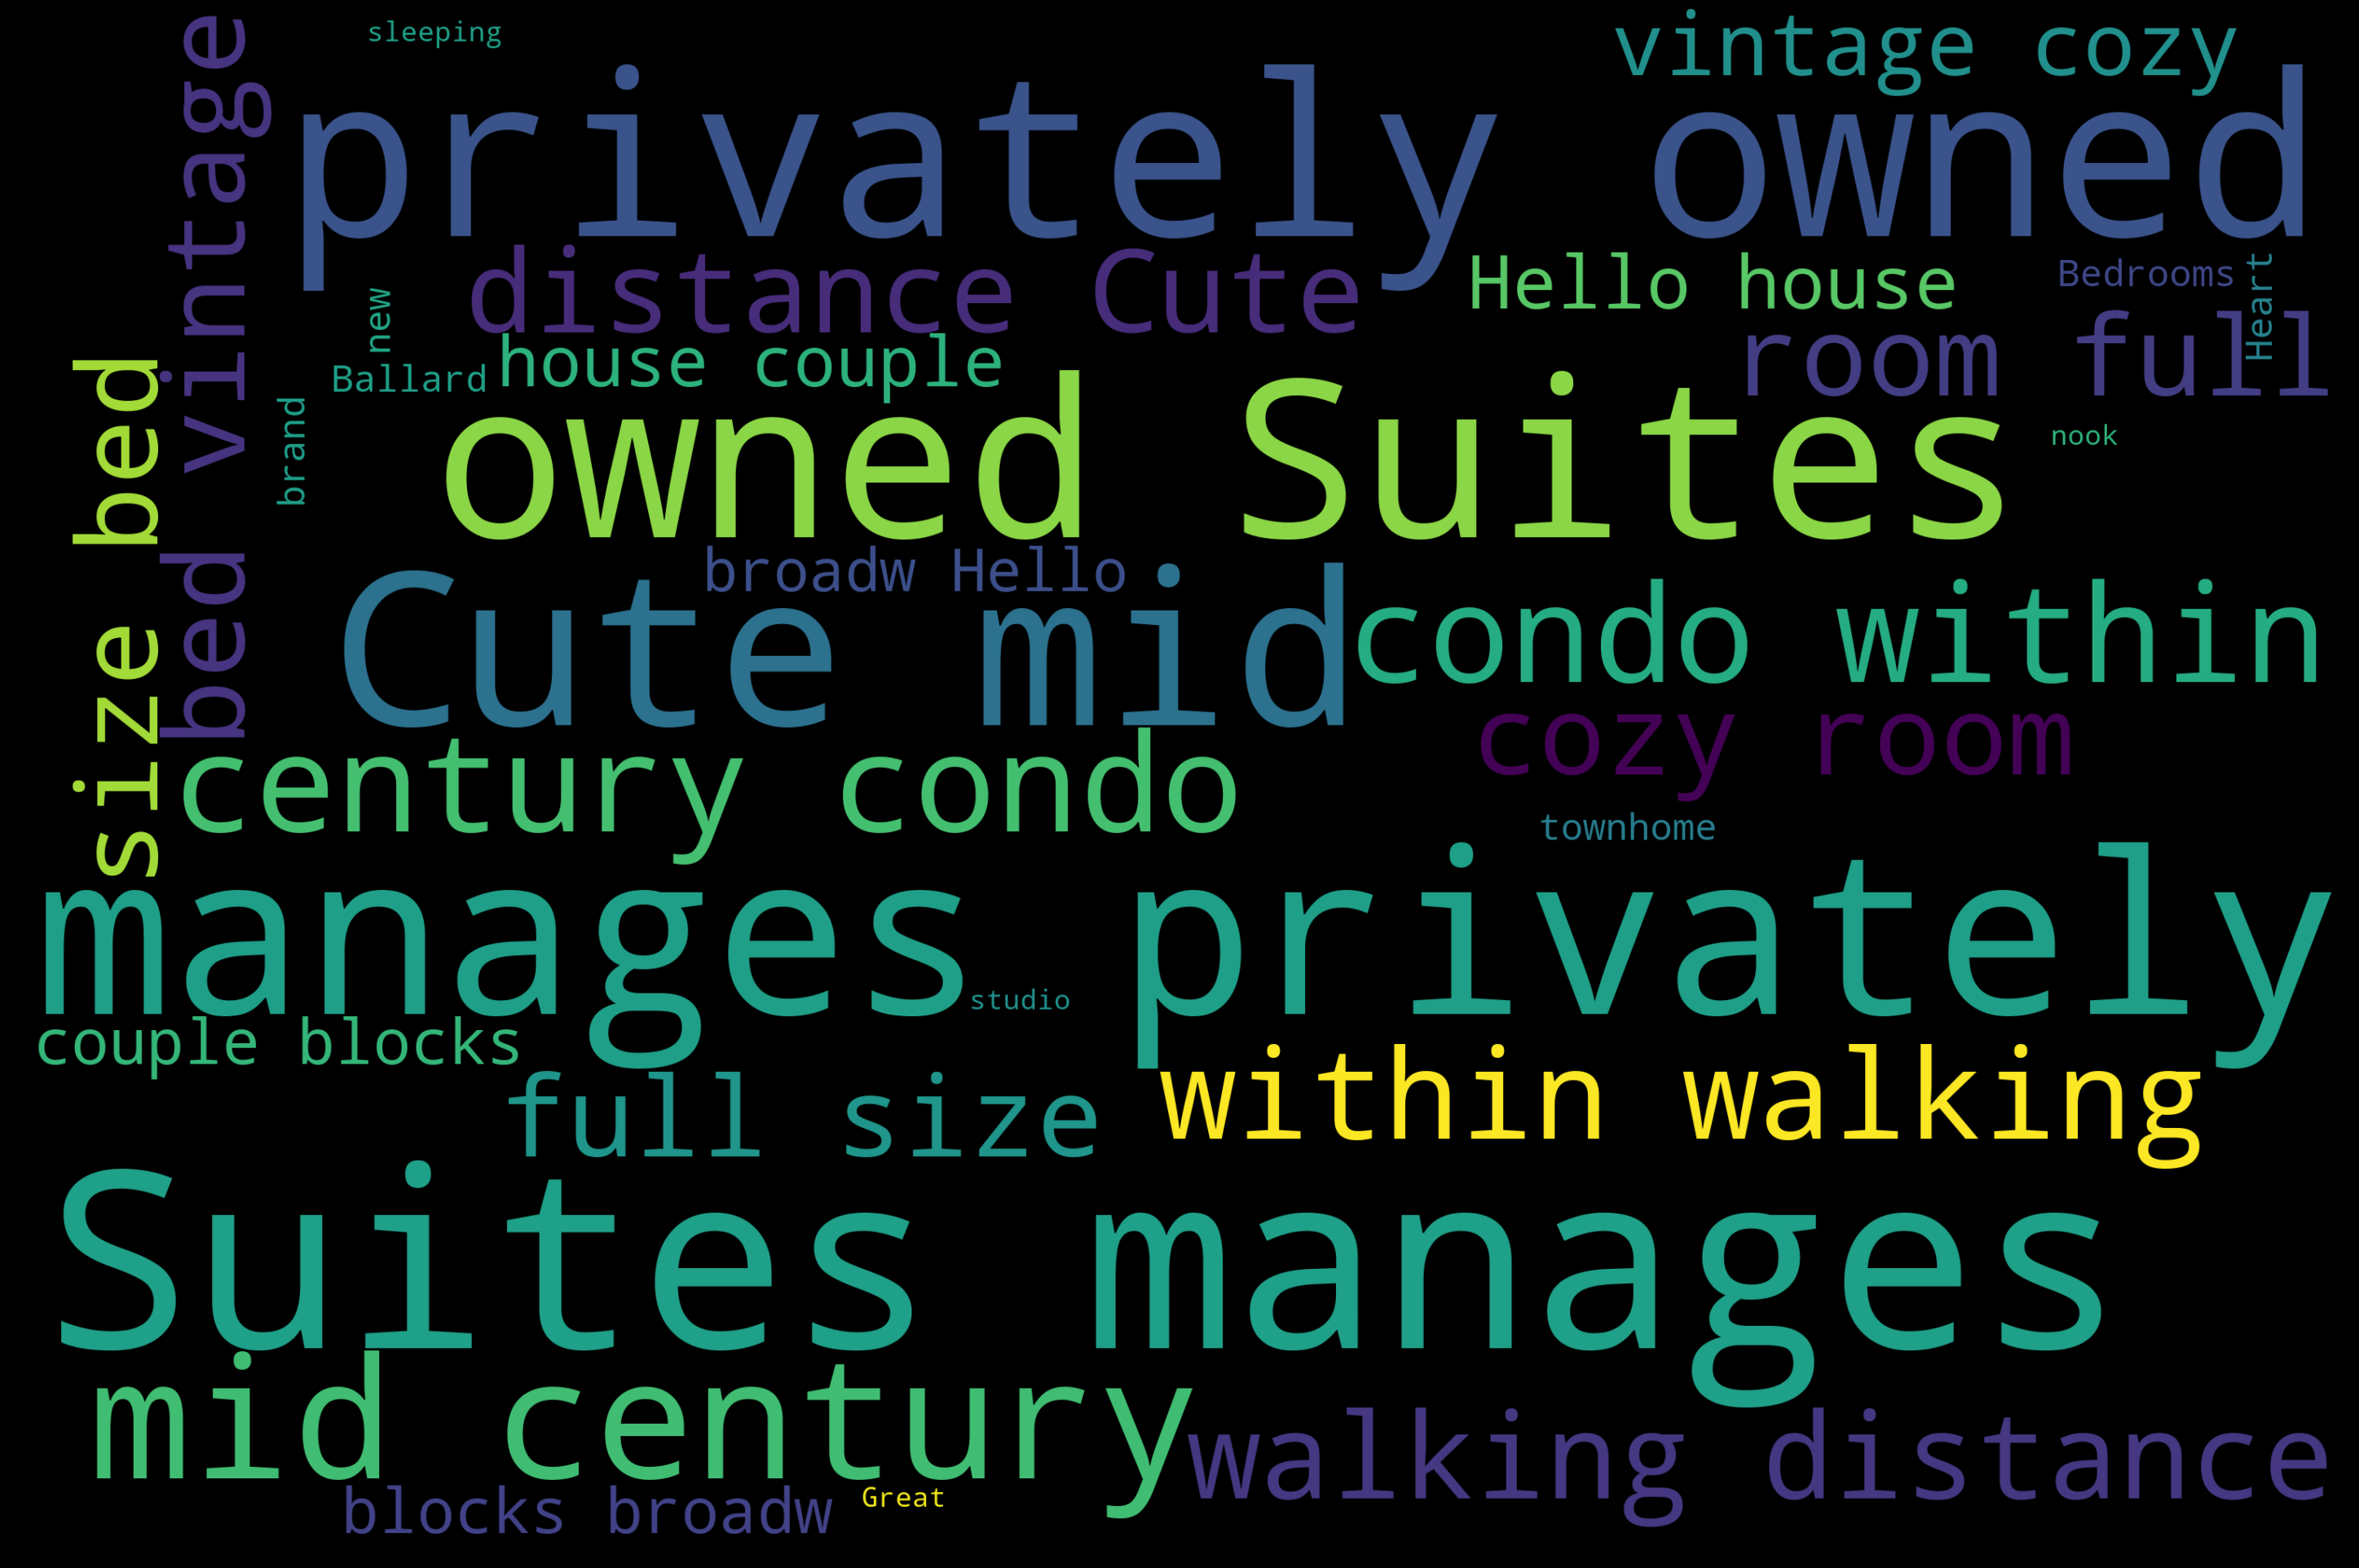

In [13]:
stopwords = set(STOPWORDS)
stopwords.update(['description', 'object', 'description', 'LLC', 'fu', 'Name', 'Length', 'Seattle', 'dtype'])

wordcloud(df_Final, 'Seattle', stopwords)

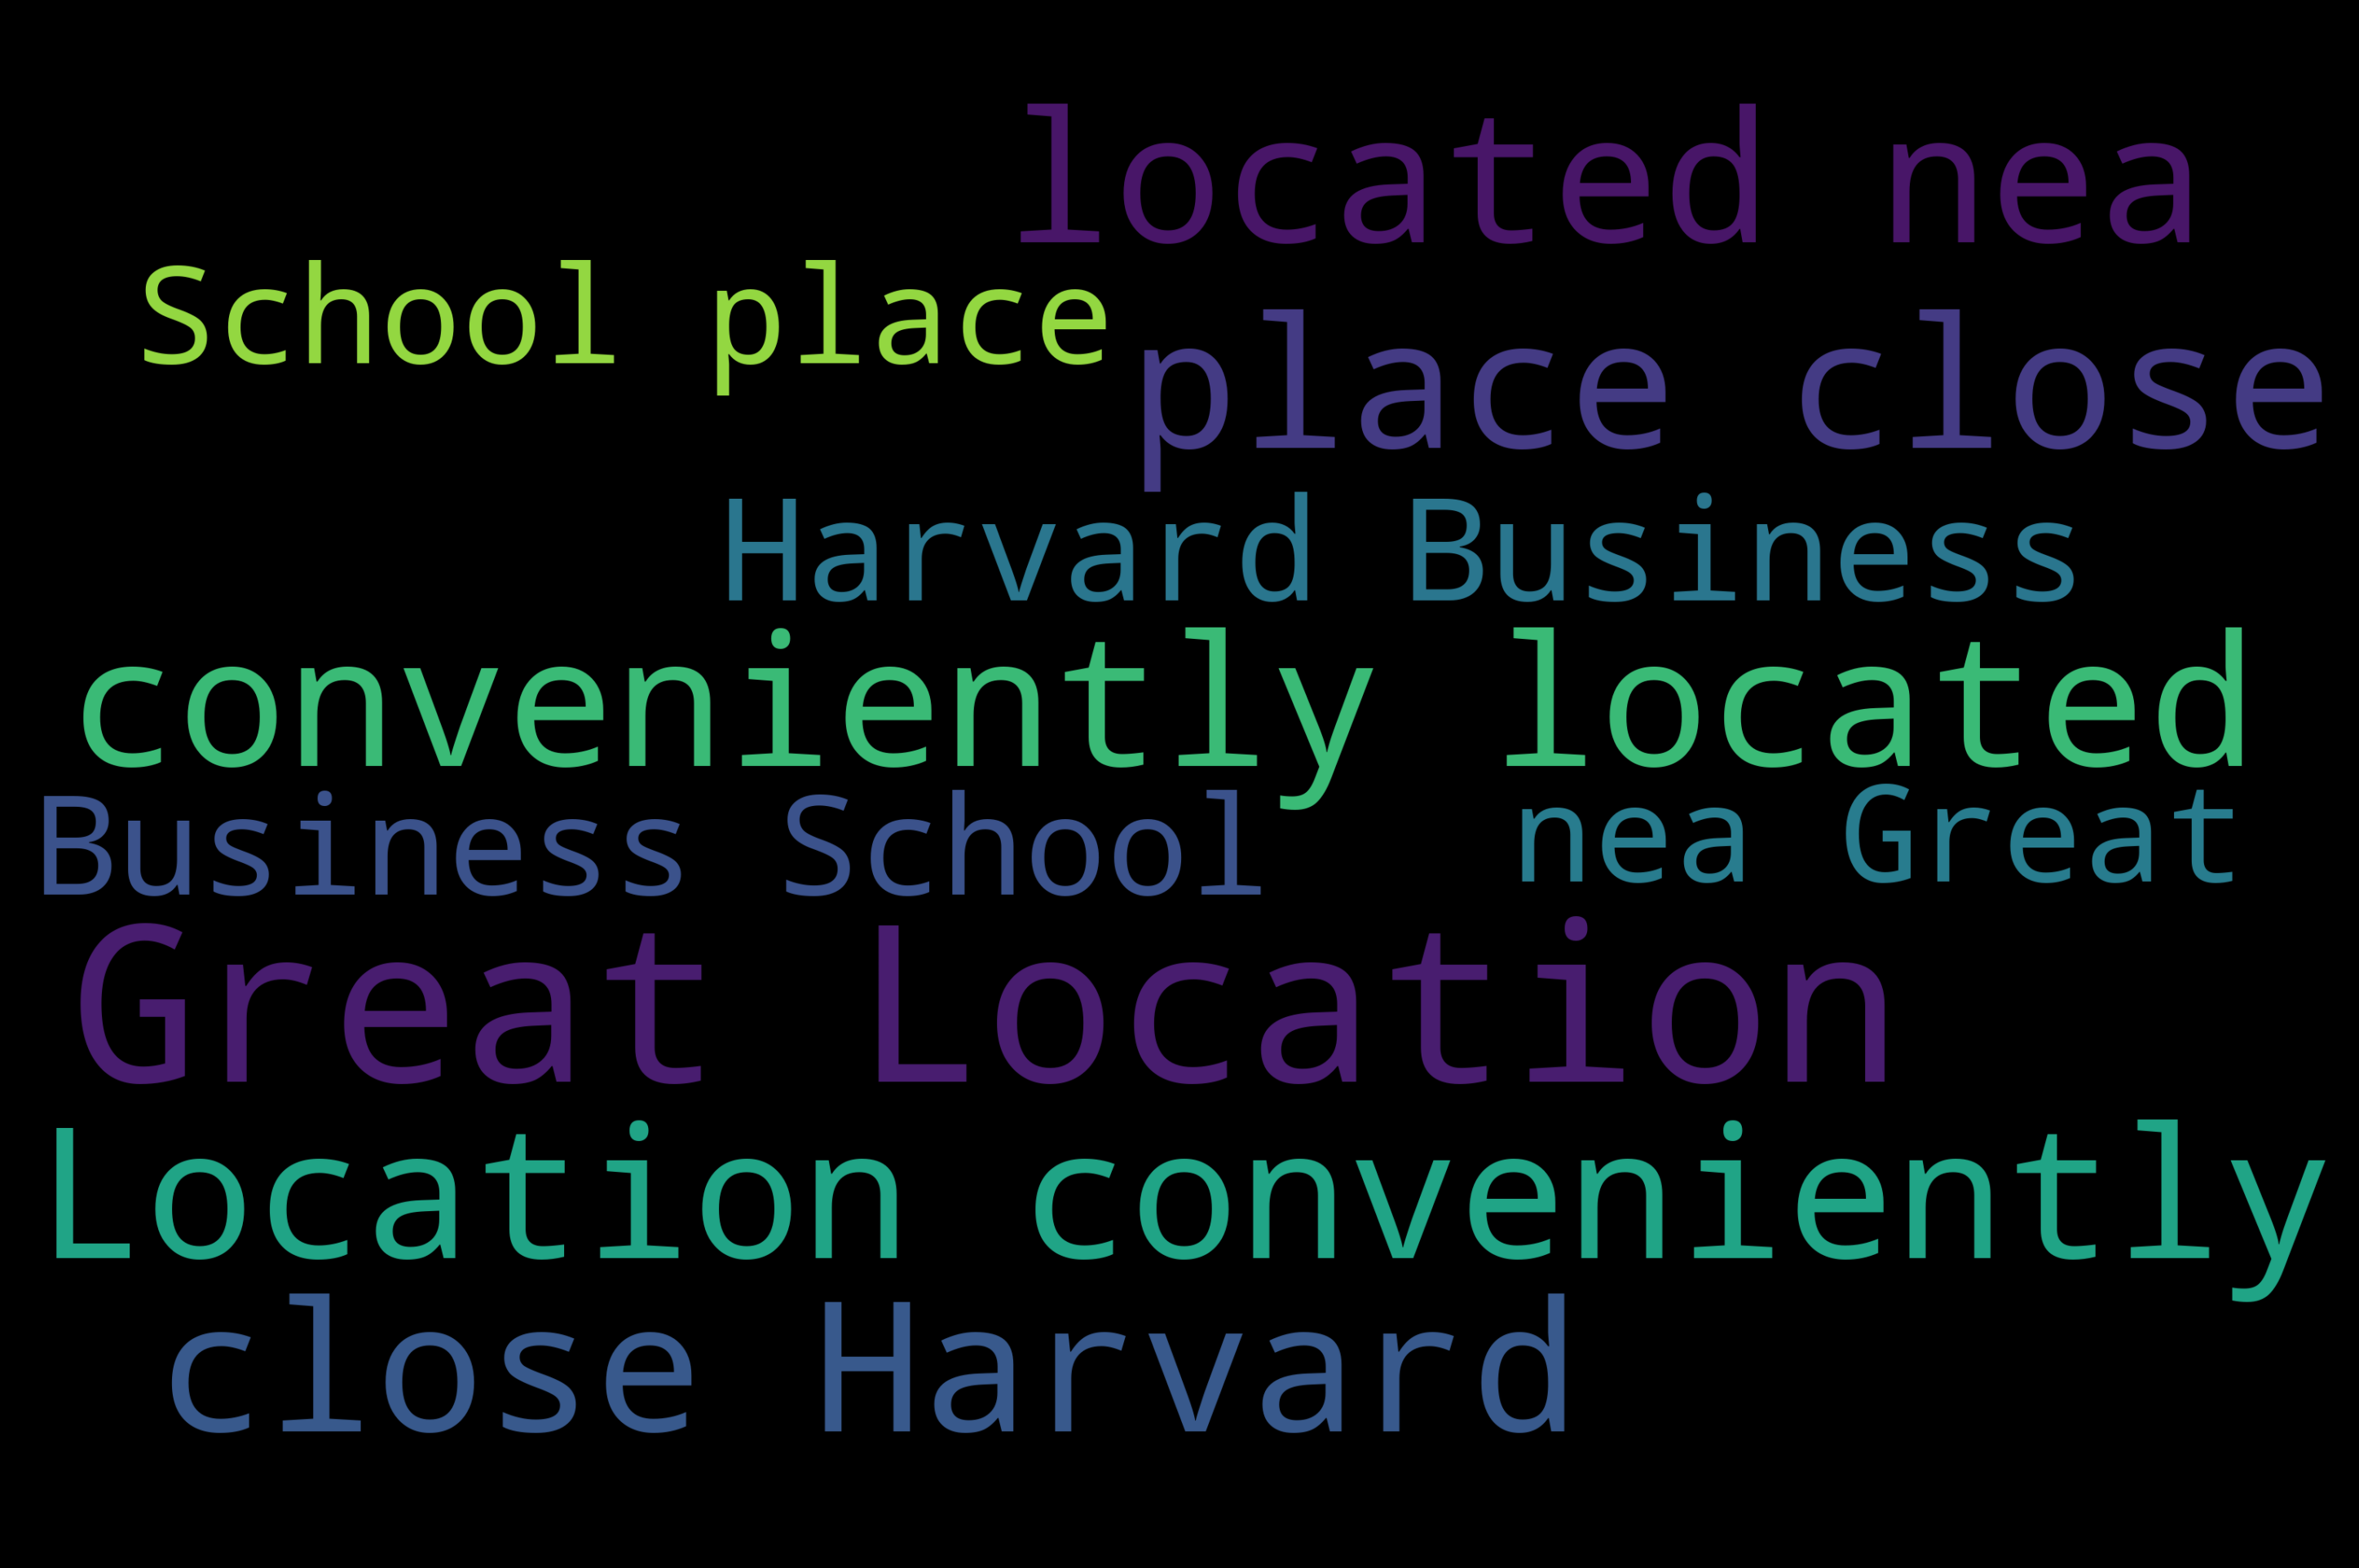

In [14]:
stopwords = set(STOPWORDS)
stopwords.update(['description', 'object', 'description', 'LLC', 'fu', 'Name', 'Length', 'Boston', 'dtype'])

wordcloud(df_Final, 'Boston', stopwords)

In [15]:
df_Seattle_sa = df_Final[df_Final.CityIndicator == 'Seattle']
df_Seattle_sa = df_Seattle_sa.drop_duplicates('description')
df_Boston_sa = df_Final[df_Final.CityIndicator == 'Boston']
df_Boston_sa = df_Boston_sa.drop_duplicates('description')

In [16]:
def sentiment(data):
    """Summary or Description of the Function:
    Get the sentiment values from the vader model
        
    Parameters:
    data (dataframe): df that is used for each city  
    

    Returns:
    dataframe
    """
    sid = SentimentIntensityAnalyzer()
    sentiment_list_neg = []
    sentiment_list_neu = []
    sentiment_list_pos = []
    sentiment_list_com = []
    sentence_list = []
    for sentence in data.description:
        ss_s = sid.polarity_scores(sentence)
        sentence_list.append(sentence)
        sentiment_list_neg.append(ss_s.get('neg'))
        sentiment_list_neu.append(ss_s.get('neu'))
        sentiment_list_pos.append(ss_s.get('pos'))
        sentiment_list_com.append(ss_s.get('compound'))    
        
    data['Negative'] = sentiment_list_neg
    data['Neutral'] = sentiment_list_neu
    data['Positive'] = sentiment_list_pos
    data['Compound'] = sentiment_list_com
    
    return(data)
    
df_Seattle_sa = sentiment(df_Seattle_sa)
df_Boston_sa = sentiment(df_Boston_sa)

# 3. What is the general feedback from the guests by city and how their stay is experienced

## Overview
Sentiment forms a big part in the overall experience of a guest, and looking at the feedback that is provided can be valuable. For this piece of work sentiment analysis was performed to look at the feedback of the guests, between the two cities. Based on this owners can decide to make some improvements to their property for then to stand out from a competitor. The boxplots below demonstrate the sentiments of the guests. 

## Outcome
### Negative sentiment

1. Boston seem to have less negative feedback, having less visitors can contribute to this. 

### Neutral

1. The feedback on Boston seem to be a bit more neutral than compared to Seattle 

### Positive

1. Seattle seem to have more positive feedback that Boston

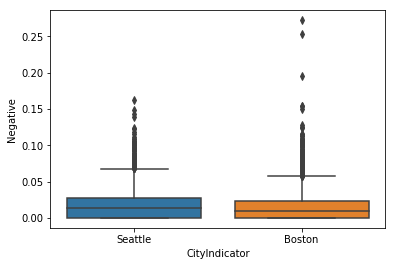

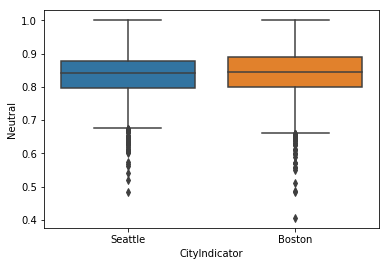

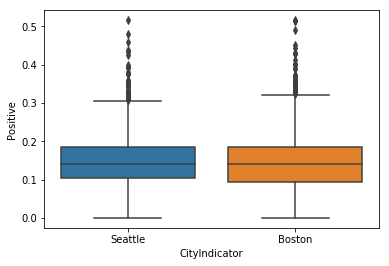

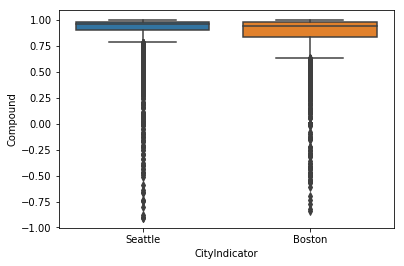

In [17]:
df_sentiment = df_Seattle_sa.append(df_Boston_sa)
for i in ['Negative', 'Neutral', 'Positive', 'Compound']:
    ax = sns.boxplot(x = df_sentiment.CityIndicator, y = df_sentiment[i])
    plt.show()

# Conclusion

We see that there is a lot more listings in Seattle compared to Boston, Seattle could be a better tourist attraction. With the competitions in Seattle being more the average price is significantly less.

In [18]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b><a href="javascript:code_toggle()">:)</a></b>''')